In [1]:
### Importing necessary libraries
import os
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt

# Accessing Data

In [2]:
### Loading matlab files in Python using Scipy
import scipy.io
mat = scipy.io.loadmat('Brain.mat')

In [3]:
T1, label = mat['T1'], mat['label']


In [4]:
data_folder = 'data'
os.makedirs('data',exist_ok=True)

In [5]:
for i in range(10):
    img = T1[:,:,i]
    ### standardising the float values between int of range(0-255)
    img = ((img - img.min()) * (1/(img.max() - img.min()) * 255)).astype('uint8')
    ###source: https://stackoverflow.com/a/49922520/9605907
    lab = label[:,:,i]
#     lab = ((lab - lab.min()) * (1/(lab.max() - lab.min()) * 5)).astype('uint8')
    cv2.imwrite(os.path.join(data_folder,f'{i}_image.jpg'),img)
    cv2.imwrite(os.path.join(data_folder,f'{i}_gt.jpg'),lab)

In [6]:
sorted(os.listdir(data_folder))

['0_gt.jpg',
 '0_image.jpg',
 '1_gt.jpg',
 '1_image.jpg',
 '2_gt.jpg',
 '2_image.jpg',
 '3_gt.jpg',
 '3_image.jpg',
 '4_gt.jpg',
 '4_image.jpg',
 '5_gt.jpg',
 '5_image.jpg',
 '6_gt.jpg',
 '6_image.jpg',
 '7_gt.jpg',
 '7_image.jpg',
 '8_gt.jpg',
 '8_image.jpg',
 '9_gt.jpg',
 '9_image.jpg']

# Visualizing sample data

In [7]:
### function to plot image
def show_image(image,cmap = 'gray',fig_size = 10):
    plt.figure(figsize = (fig_size,fig_size))
    fig  = plt.imshow(image,cmap = cmap)
    plt.show()

### function to visualise the segmentation
def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # convert hsv2bgr for visualsiation
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set background label to black
    labeled_img[label_hue==0] = 0
    return labeled_img

### input image

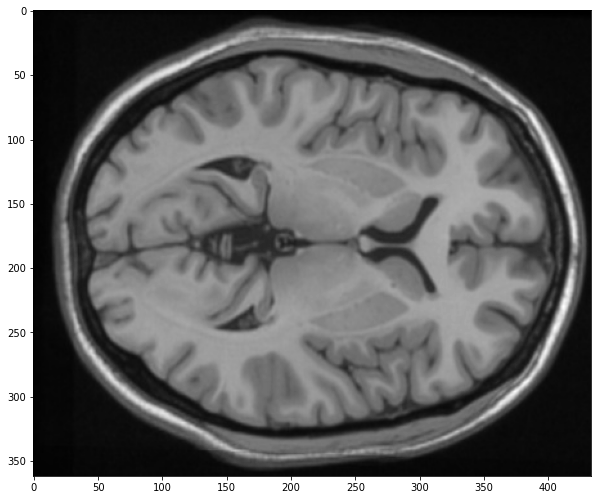

In [8]:

input_image = cv2.imread(os.path.join(data_folder,'0_image.jpg'),cv2.IMREAD_UNCHANGED)
show_image(input_image)

### Expected segmented image

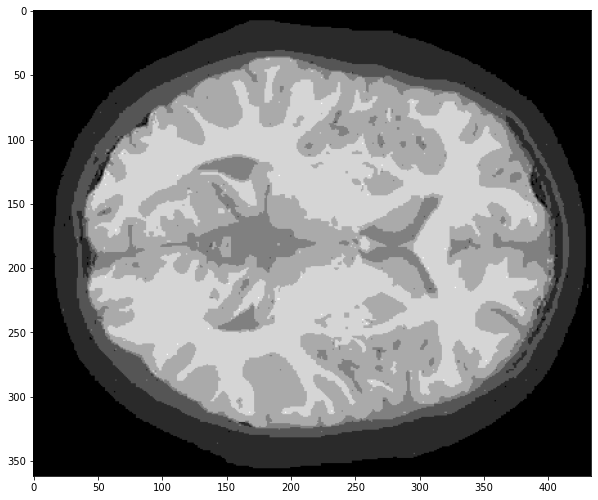

In [85]:

label_image = cv2.imread(os.path.join(data_folder,'0_gt.jpg'),cv2.IMREAD_UNCHANGED)
show_image(label_image)

In [86]:
label_image.shape

(362, 434)

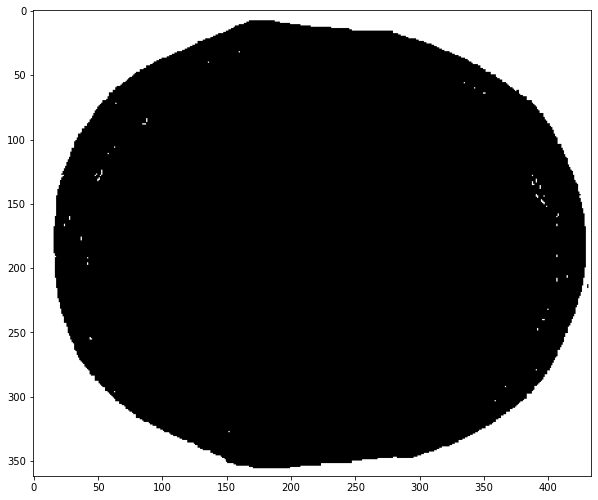

In [87]:
show_image(label_image==0)

-  From the given set of images, we need to arrive at a segmentation algorithm that can segment the given input into the following labels:

    • Label 0 = air 
    • Label 1 = skin/scalp 
    • Label 2 = skull 
    • Label 3 = CSF 
    • Label 4 = Gray Matter 
    • Label 5 = White Matter 

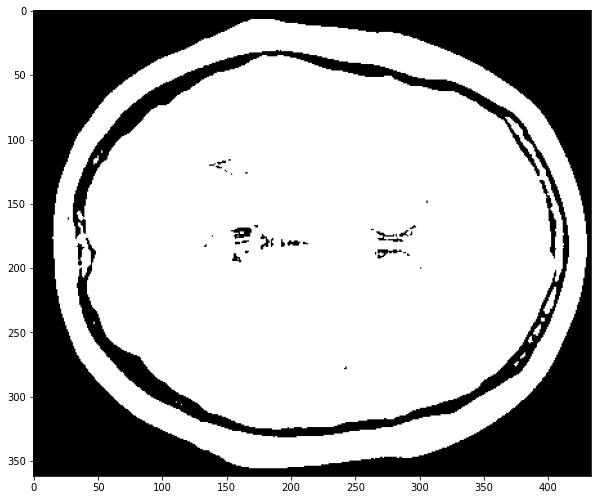

In [14]:
#### basic Thresholding

th, dst = cv2.threshold(input_image, 40, 255, cv2.THRESH_BINARY)
show_image(dst)

In [15]:
dst.shape

(362, 434)

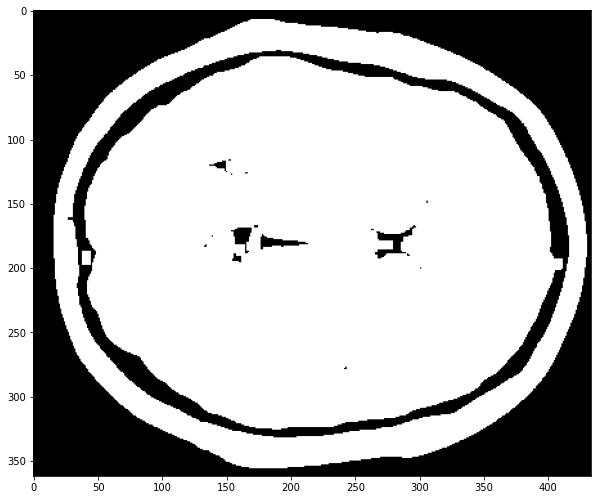

In [16]:
kernel = np.ones((3,3),dtype=np.uint8)
new_image = cv2.morphologyEx(dst, cv2.MORPH_OPEN, kernel,iterations = 3)
show_image(new_image)

In [27]:
### canny edge detection

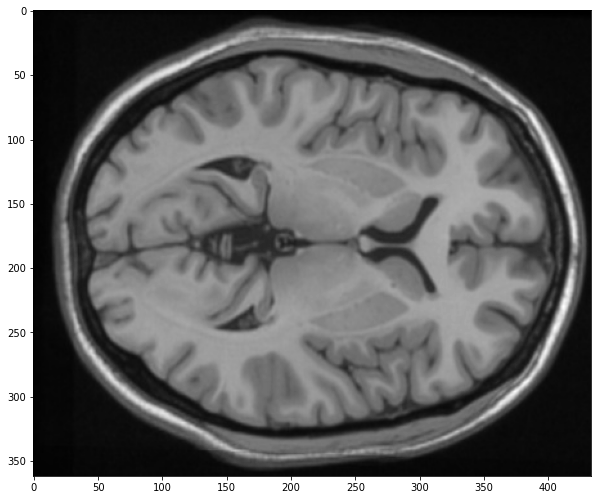

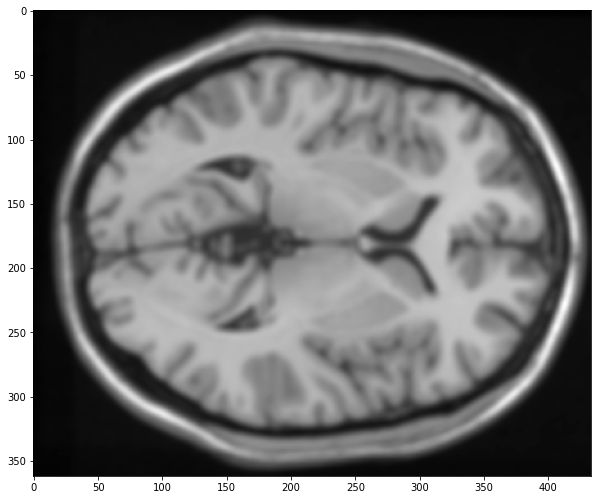

In [61]:
show_image(input_image)
blur_image = cv2.GaussianBlur(input_image,(7,7),cv2.BORDER_DEFAULT)
show_image(blur_image)

(0.0, 256.0)

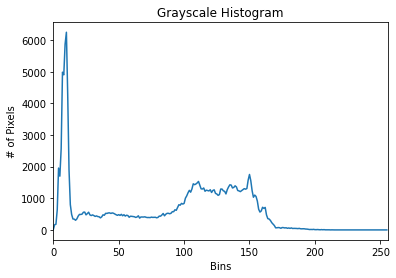

In [62]:
hist = cv2.calcHist([blur_image], [0], None, [256], [0, 256])
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
plt.plot(hist)
plt.xlim([0, 256])

In [65]:
np.argmax(hist)

10

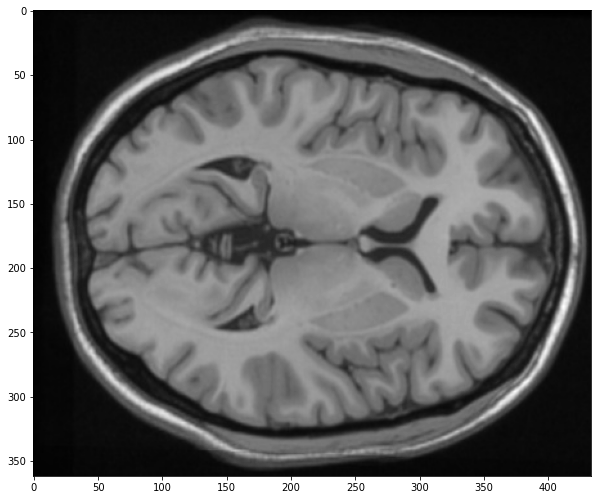

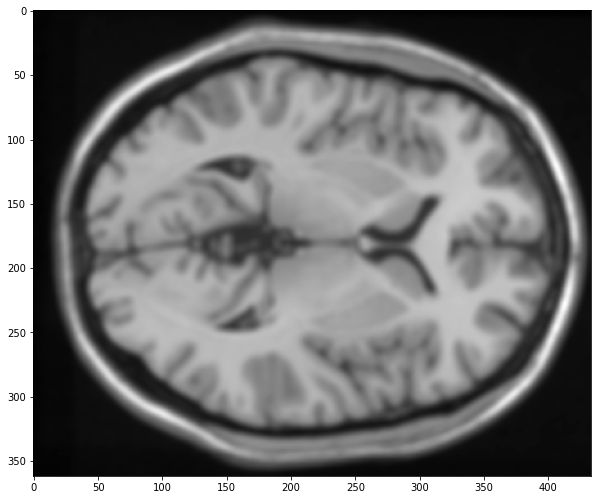

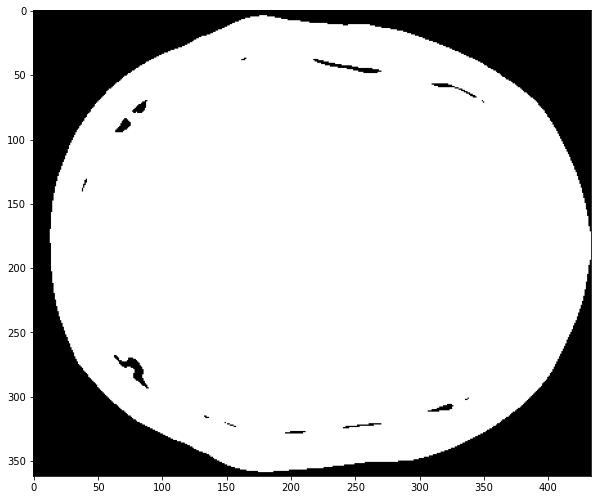

In [55]:
th, dst = cv2.threshold(blur_image, 20, 255, cv2.THRESH_BINARY)
show_image(dst)

# edges = cv2.Canny(blur_image,40,100)
# show_image(edges)

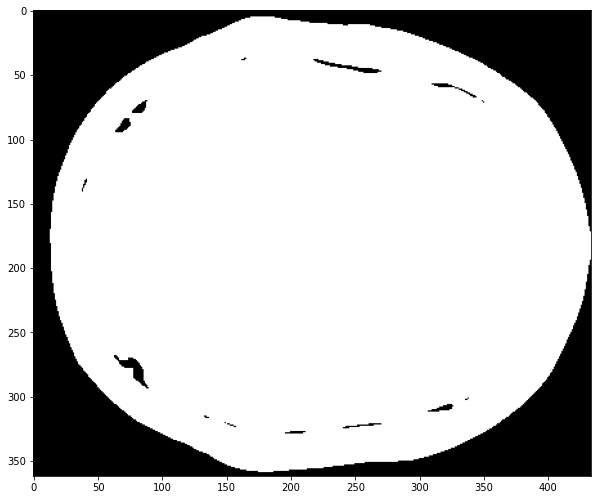

In [60]:
kernel = np.ones((3,3),dtype=np.uint8)
new_image = cv2.morphologyEx(dst, cv2.MORPH_OPEN, kernel,iterations = 3)
show_image(new_image)

(0.0, 256.0)

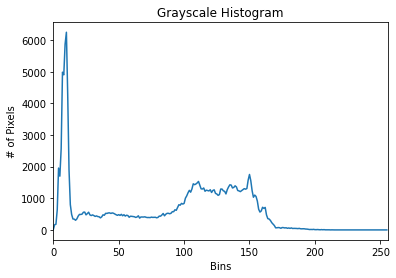

In [52]:
max_val = np.argmax(hist)
max_val

10

In [48]:
new_image.shape

(362, 434)

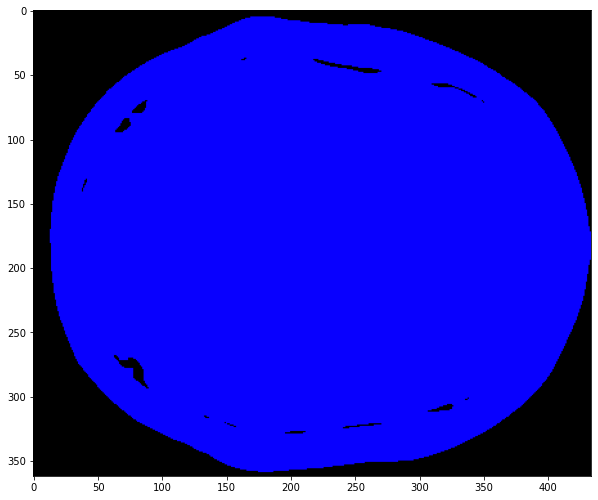

In [66]:
retval, out_label, stats, centroids = cv2.connectedComponentsWithStats(new_image)

show_image(imshow_components(out_label))

In [67]:
def watershed_layout(binary):
    markers=np.zeros_like(binary,dtype=np.uint8)
    try:
        image=cv2.cvtColor(binary,cv2.COLOR_GRAY2BGR)
        kernel = np.ones((3,3),np.uint8)
        # sure background area
        sure_bg = cv2.dilate(binary,kernel,iterations=3)
        # Finding sure foreground area
        dist_transform = cv2.distanceTransform(binary,cv2.DIST_L2,5)
        ret, sure_fg = cv2.threshold(dist_transform,0.015*dist_transform.max(),255,0)

        # Finding unknown region
        sure_fg = np.uint8(sure_fg)
        unknown = cv2.subtract(sure_bg,sure_fg)
        # Marker labelling
        ret, markers = cv2.connectedComponents(sure_fg)

        # Add one to all labels so that sure background is not 0, but 1
        markers = markers+1
        # Now, mark the region of unknown with zero
        markers[unknown==255] = 0
        markers = cv2.watershed(image,markers)
        markers=markers+1
    except Exception as e:
        print('watershed algo error')
        print(e)
    return markers


In [68]:
out = watershed_layout(new_image)

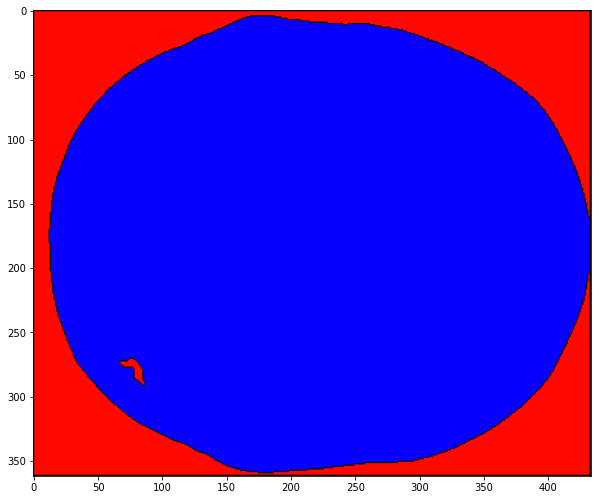

In [69]:
show_image(imshow_components(out))

# Evaluation

In [88]:
def categorical_dice(mask1, mask2, label_class = 1):
    """
    Dice score of a specified class between two volumes of label masks.
    (classes are encoded but by label class number not one-hot )
    Note: stacks of 2D slices are considered volumes.

    Args:
        mask1: N label masks, numpy array shaped (H, W, N)
        mask2: N label masks, numpy array shaped (H, W, N)
        label_class: the class over which to calculate dice scores

    Returns:
        volume_dice
    """
    mask1_pos = (mask1 == label_class).astype(np.float32)
    mask2_pos = (mask2 == label_class).astype(np.float32)
    dice = 2 * np.sum(mask1_pos * mask2_pos) / (np.sum(mask1_pos) + np.sum(mask2_pos))
    return dice

In [92]:
def pixelwise_IOU(input_image, ground_truth, label_class = 1):
    mask1 = input_image == label_class
    mask2 = ground_truth == label_class
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

In [93]:
### evaluating for each class
label_list = list(range(0,6))
label_list =[0]
dice_score = []

for l in label_list:
    iou = pixelwise_IOU(new_image, label_image, l)
    dice = categorical_dice(new_image, label_image, l)
    print(f"iou for label {l} is {round(iou,3)}")
    print(f"dice for label {l} is {round(dice,3)}")


iou for label 0 is 0.902
dice for lable 0 is 0.948
